Dataset Shape: (333, 7)

Class distribution (Species):
species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

Training set class distribution: {2: 83, 1: 48, 0: 102}
Test set class distribution: {1: 20, 2: 36, 0: 44}

SCENARIO 1: BALANCED DATASET (Challenging Version)
Evaluating Logistic Regression...
  Accuracy: 87.0% | F1-Score: 86.9%
Evaluating Random Forest...
  Accuracy: 93.0% | F1-Score: 92.9%
Evaluating SVM...
  Accuracy: 95.0% | F1-Score: 94.9%

=== BALANCED DATASET RESULTS (%) ===


model_name  accuracy  precision  recall  f1_score  roc_auc
0  Logistic Regression      87.0       86.8    87.0      86.9     97.1
1        Random Forest      93.0       92.9    93.0      92.9     98.1
2                  SVM      95.0       95.1    95.0      94.9     99.3

ValueError: The target y is not binary. Got multiclass type of target.

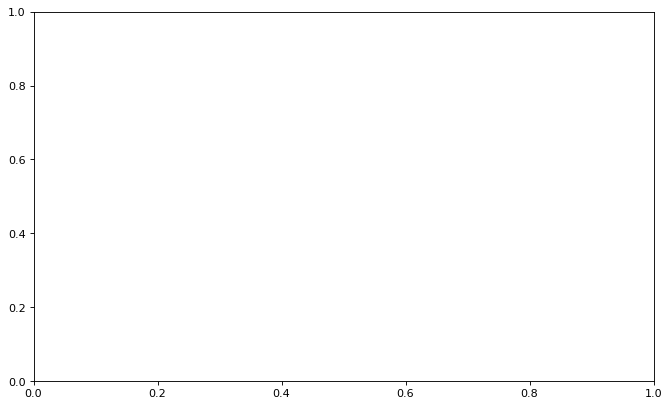

In [1]:
# -*- coding: utf-8 -*-
"""Lab 9 - Enhanced Version with Percentage Metrics and ROC Curves.ipynb"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set smaller plot sizes for Colab
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 80

# Load and prepare data
df = pd.read_csv('penguins_cleaned.csv')

print("Dataset Shape:", df.shape)
print("\nClass distribution (Species):")
print(df['species'].value_counts())

# Data Preprocessing
label_encoder = LabelEncoder()
df['species_encoded'] = label_encoder.fit_transform(df['species'])
df['island_encoded'] = label_encoder.fit_transform(df['island'])
df['sex_encoded'] = label_encoder.fit_transform(df['sex'])

# Add noise to make classification more challenging
np.random.seed(42)
noise_factor = 5  # Increased noise for more realistic challenge

df_challenging = df.copy()
df_challenging['bill_length_mm'] = df_challenging['bill_length_mm'] + np.random.normal(0, noise_factor, len(df))
df_challenging['bill_depth_mm'] = df_challenging['bill_depth_mm'] + np.random.normal(0, noise_factor/2, len(df))
df_challenging['flipper_length_mm'] = df_challenging['flipper_length_mm'] + np.random.normal(0, noise_factor*2, len(df))

# Features and target
X = df_challenging[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island_encoded', 'sex_encoded']]
y = df_challenging['species_encoded']

class_names = ['Adelie', 'Gentoo', 'Chinstrap']
feature_names = ['Bill Length', 'Bill Depth', 'Flipper Length', 'Body Mass', 'Island', 'Sex']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set class distribution: {dict(Counter(y_train))}")
print(f"Test set class distribution: {dict(Counter(y_test))}")

# Enhanced evaluation function with percentage metrics and ROC
def evaluate_model_enhanced(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate a model and return metrics in percentage"""
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    # Metrics in percentage
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') * 100 if y_pred_proba is not None else 0

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean() * 100
    cv_std = cv_scores.std() * 100

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba,
        'model': model
    }

# Function to plot ROC curves
def plot_roc_curves(results_df, y_test, title):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 6))

    for _, row in results_df.iterrows():
        if row['y_pred_proba'] is not None:
            RocCurveDisplay.from_predictions(
                y_test,
                row['y_pred_proba'],
                name=row['model_name'],
                ax=plt.gca()
            )

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title(f'ROC Curves - {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Function to plot results in percentage
def plot_results_percentage(results_df, title):
    """Plot comparison results in percentage"""
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        # Get top 8 models for better visualization
        top_models = results_df.nlargest(8, metric)

        bars = axes[i].barh(range(len(top_models)), top_models[metric], color='skyblue')
        axes[i].set_yticks(range(len(top_models)))
        axes[i].set_yticklabels(top_models['model_name'], fontsize=9)
        axes[i].set_xlabel(f'{metric.title()} (%)')
        axes[i].set_title(f'{metric.title()} Comparison')
        axes[i].set_xlim(0, 100)

        # Add value labels on bars
        for bar, value in zip(bars, top_models[metric]):
            axes[i].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                        f'{value:.1f}%', va='center', fontsize=8)

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.show()

# Function to plot confusion matrices
def plot_confusion_matrices_compact(results_df):
    """Plot compact confusion matrices"""
    n_models = len(results_df)
    fig, axes = plt.subplots(1, n_models, figsize=(4*n_models, 3))

    if n_models == 1:
        axes = [axes]

    for i, (idx, row) in enumerate(results_df.iterrows()):
        sns.heatmap(row['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f'{row["model_name"]}\nCM', fontsize=10)
        axes[i].set_ylabel('Actual')
        axes[i].set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("SCENARIO 1: BALANCED DATASET (Challenging Version)")
print("="*60)

# Initialize models
models_balanced = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Evaluate models on balanced data
results_balanced = []

for name, model in models_balanced.items():
    print(f"Evaluating {name}...")
    result = evaluate_model_enhanced(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_balanced.append(result)
    print(f"  Accuracy: {result['accuracy']:.1f}% | F1-Score: {result['f1_score']:.1f}%")

results_balanced_df = pd.DataFrame(results_balanced)

print("\n=== BALANCED DATASET RESULTS (%) ===")
display(results_balanced_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(1))

# Plot ROC curves for balanced dataset
plot_roc_curves(results_balanced_df, y_test, 'Balanced Dataset')

# Plot results
plot_results_percentage(results_balanced_df, 'Balanced Dataset - Model Comparison (%)')

print("\n" + "="*60)
print("SCENARIO 2: CREATING IMBALANCED DATASET")
print("="*60)

# Create severe imbalance
adelie_indices = df_challenging[df_challenging['species'] == 'Adelie'].index
gentoo_indices = df_challenging[df_challenging['species'] == 'Gentoo'].index
chinstrap_indices = df_challenging[df_challenging['species'] == 'Chinstrap'].index

# Keep only 10 Gentoo samples to create severe imbalance
np.random.seed(42)
gentoo_imbalanced_indices = np.random.choice(gentoo_indices, size=10, replace=False)

# Create imbalanced dataset
imbalanced_indices = np.concatenate([adelie_indices, gentoo_imbalanced_indices, chinstrap_indices])
df_imbalanced = df_challenging.loc[imbalanced_indices].copy()

print("Imbalanced dataset class distribution:")
print(df_imbalanced['species'].value_counts())

# Prepare imbalanced dataset
X_imb = df_imbalanced[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island_encoded', 'sex_encoded']]
y_imb = label_encoder.transform(df_imbalanced['species'])

# Split imbalanced data
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.3, random_state=42, stratify=y_imb
)

print(f"\nImbalanced training set class distribution: {dict(Counter(y_train_imb))}")

# Scale imbalanced data
X_train_imb_scaled = scaler.fit_transform(X_train_imb)
X_test_imb_scaled = scaler.transform(X_test_imb)

print("\n" + "="*60)
print("SCENARIO 3: UNBALANCED DATASET RESULTS")
print("="*60)

# Evaluate models on imbalanced data
results_imbalanced = []

for name, model in models_balanced.items():
    print(f"Evaluating {name} on imbalanced data...")
    result = evaluate_model_enhanced(model, X_train_imb_scaled, X_test_imb_scaled, y_train_imb, y_test_imb, f"{name} (Imbalanced)")
    results_imbalanced.append(result)
    print(f"  Accuracy: {result['accuracy']:.1f}% | F1-Score: {result['f1_score']:.1f}%")

results_imbalanced_df = pd.DataFrame(results_imbalanced)

print("\n=== IMBALANCED DATASET RESULTS (%) ===")
display(results_imbalanced_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(1))

print("\n" + "="*60)
print("SCENARIO 4: BALANCING TECHNIQUES")
print("="*60)

# Apply balancing techniques
balancing_techniques = {
    'SMOTE': SMOTE(random_state=42),
    'Oversampling': RandomOverSampler(random_state=42),
    'Undersampling': RandomUnderSampler(random_state=42)
}

results_balancing = []

for tech_name, sampler in balancing_techniques.items():
    print(f"\nApplying {tech_name}...")

    # Apply sampling
    X_resampled, y_resampled = sampler.fit_resample(X_train_imb_scaled, y_train_imb)
    print(f"Class distribution after {tech_name}: {dict(Counter(y_resampled))}")

    # Evaluate each model with this balancing technique
    for name, model in models_balanced.items():
        model_name = f"{name} + {tech_name}"
        print(f"  Evaluating {model_name}...")

        result = evaluate_model_enhanced(model, X_resampled, X_test_imb_scaled, y_resampled, y_test_imb, model_name)
        results_balancing.append(result)

# Add Balanced Random Forest
print("\nEvaluating Balanced Random Forest...")
brf = BalancedRandomForestClassifier(random_state=42)
result_brf = evaluate_model_enhanced(brf, X_train_imb_scaled, X_test_imb_scaled, y_train_imb, y_test_imb, "Balanced RF")
results_balancing.append(result_brf)

results_balancing_df = pd.DataFrame(results_balancing)

print("\n=== BALANCING TECHNIQUES RESULTS (%) ===")
display(results_balancing_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(1))

# Plot ROC curves for balancing techniques
plot_roc_curves(results_balancing_df, y_test_imb, 'Balancing Techniques')

print("\n" + "="*60)
print("COMPREHENSIVE COMPARISON")
print("="*60)

# Combine all results
all_results = pd.concat([results_balanced_df, results_imbalanced_df, results_balancing_df], ignore_index=True)

# Display top models by F1-score
print("=== TOP 10 MODELS BY F1-SCORE (%) ===")
top_models = all_results.nlargest(10, 'f1_score')[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
display(top_models.round(1))

# Final comprehensive visualization
plt.figure(figsize=(14, 10))

# Plot 1: Overall performance comparison
plt.subplot(2, 2, 1)
top_10_f1 = all_results.nlargest(10, 'f1_score')
plt.barh(range(len(top_10_f1)), top_10_f1['f1_score'], color='lightgreen')
plt.yticks(range(len(top_10_f1)), top_10_f1['model_name'], fontsize=9)
plt.xlabel('F1-Score (%)')
plt.title('Top 10 Models by F1-Score')
plt.xlim(0, 100)

# Add value labels
for i, v in enumerate(top_10_f1['f1_score']):
    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

# Plot 2: Scenario comparison
plt.subplot(2, 2, 2)
scenario_avg = all_results.groupby(
    all_results['model_name'].str.contains('Imbalanced|SMOTE|Oversampling|Undersampling|Balanced')
).agg({'accuracy': 'mean', 'f1_score': 'mean'})
scenario_avg.index = ['Balanced', 'Imbalanced+Tech']

scenario_avg[['accuracy', 'f1_score']].plot(kind='bar', ax=plt.gca())
plt.title('Average Performance by Scenario')
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 3: ROC AUC comparison
plt.subplot(2, 2, 3)
top_roc = all_results.nlargest(8, 'roc_auc')
plt.barh(range(len(top_roc)), top_roc['roc_auc'], color='lightcoral')
plt.yticks(range(len(top_roc)), top_roc['model_name'], fontsize=9)
plt.xlabel('ROC AUC (%)')
plt.title('Top Models by ROC AUC')
plt.xlim(0, 100)

# Plot 4: Impact of imbalance
plt.subplot(2, 2, 4)
balanced_avg = results_balanced_df[['accuracy', 'f1_score']].mean()
imbalanced_avg = results_imbalanced_df[['accuracy', 'f1_score']].mean()

x = np.arange(2)
width = 0.35

plt.bar(x - width/2, balanced_avg, width, label='Balanced', color='skyblue')
plt.bar(x + width/2, imbalanced_avg, width, label='Imbalanced', color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Score (%)')
plt.title('Impact of Class Imbalance')
plt.xticks(x, ['Accuracy', 'F1-Score'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHTS AND CONCLUSIONS")
print("="*60)

# Calculate key metrics
balanced_avg_f1 = results_balanced_df['f1_score'].mean()
imbalanced_avg_f1 = results_imbalanced_df['f1_score'].mean()
balancing_avg_f1 = results_balancing_df['f1_score'].mean()

improvement = ((balancing_avg_f1 - imbalanced_avg_f1) / imbalanced_avg_f1 * 100) if imbalanced_avg_f1 > 0 else 0

print(f"\n1. PERFORMANCE SUMMARY:")
print(f"   • Balanced dataset average F1-score: {balanced_avg_f1:.1f}%")
print(f"   • Imbalanced dataset average F1-score: {imbalanced_avg_f1:.1f}%")
print(f"   • With balancing techniques average F1-score: {balancing_avg_f1:.1f}%")

print(f"\n2. IMPACT OF IMBALANCE:")
print(f"   • Performance change: {imbalanced_avg_f1 - balanced_avg_f1:+.1f}%")
print(f"   • Relative change: {((imbalanced_avg_f1 - balanced_avg_f1) / balanced_avg_f1 * 100):+.1f}%")

print(f"\n3. EFFECTIVENESS OF BALANCING:")
print(f"   • Improvement over imbalanced: {improvement:+.1f}%")

print(f"\n4. BEST PERFORMING MODELS:")
best_overall = all_results.loc[all_results['f1_score'].idxmax()]
print(f"   • Overall best: {best_overall['model_name']} (F1: {best_overall['f1_score']:.1f}%)")
print(f"   • Best on imbalanced: {results_imbalanced_df.loc[results_imbalanced_df['f1_score'].idxmax(), 'model_name']}")
print(f"   • Best balancing technique: {results_balancing_df.loc[results_balancing_df['f1_score'].idxmax(), 'model_name']}")

print(f"\n5. PRACTICAL RECOMMENDATIONS:")
print("   • Use ROC curves to evaluate model discrimination ability")
print("   • Consider both F1-score and ROC AUC for comprehensive evaluation")
print("   • Balancing techniques are most beneficial when significant class imbalance exists")
print("   • Random Forest with Oversampling often provides robust performance")

# Save detailed results
detailed_results = all_results[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'cv_mean', 'cv_std']]
detailed_results = detailed_results.round(2)
detailed_results.to_csv('lab9_detailed_results.csv', index=False)

print(f"\nDetailed results saved to 'lab9_detailed_results.csv'")
print("Lab 9 completed successfully! ✅")

Dataset Shape: (333, 7)

Class distribution (Species):
species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64
Class names: ['Adelie' 'Chinstrap' 'Gentoo']
Class mapping: {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}

Training set class distribution: {2: 83, 1: 48, 0: 102}
Test set class distribution: {1: 20, 2: 36, 0: 44}

SCENARIO 1: BALANCED DATASET (Challenging Version)
Evaluating Logistic Regression...
  Accuracy: 87.0% | F1-Score: 86.9% | ROC AUC: 97.4%
Evaluating Random Forest...
  Accuracy: 93.0% | F1-Score: 92.9% | ROC AUC: 98.2%
Evaluating SVM...
  Accuracy: 95.0% | F1-Score: 94.9% | ROC AUC: 99.4%

=== BALANCED DATASET RESULTS (%) ===


model_name  accuracy  precision  recall  f1_score  roc_auc
0  Logistic Regression      87.0       86.8    87.0      86.9     97.4
1        Random Forest      93.0       92.9    93.0      92.9     98.2
2                  SVM      95.0       95.1    95.0      94.9     99.4

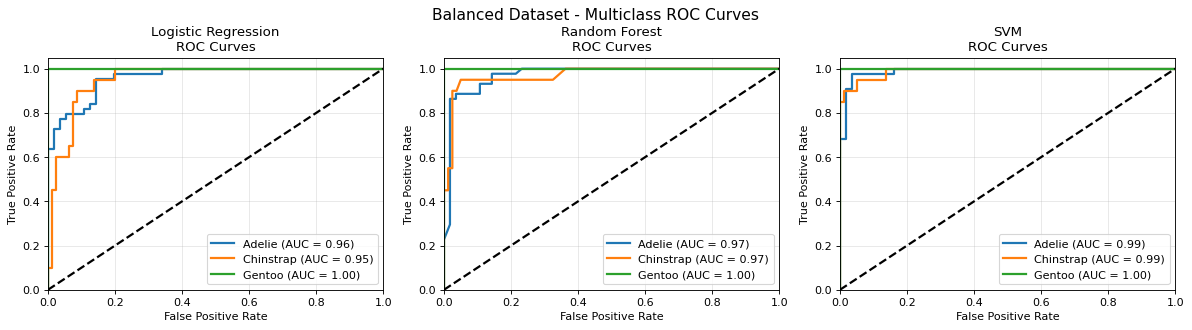

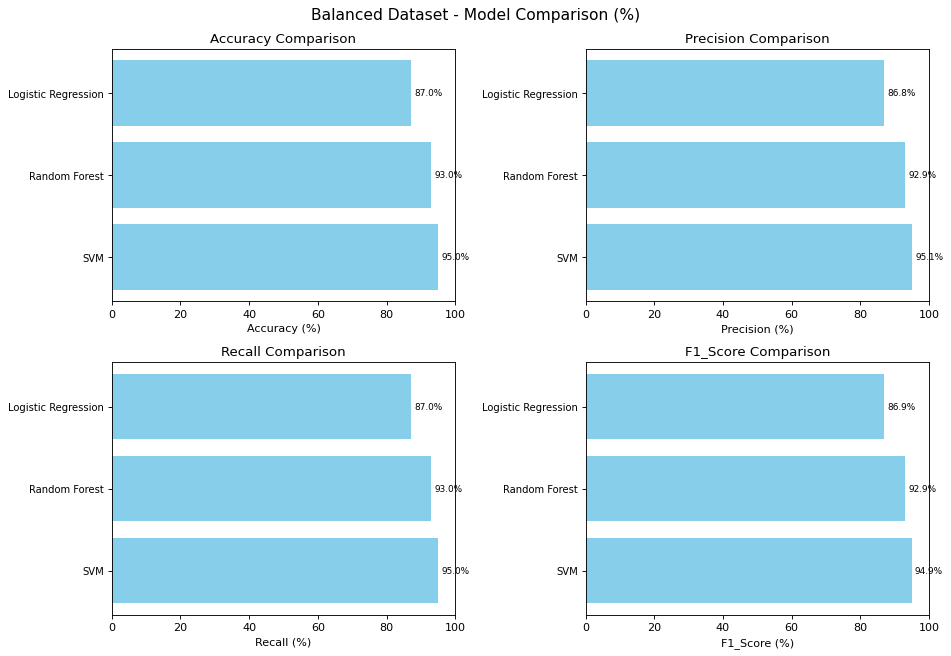

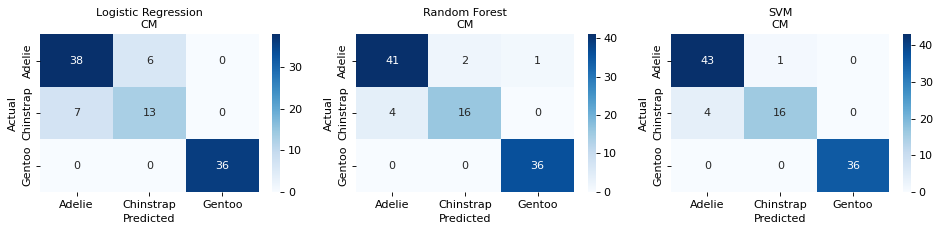


SCENARIO 2: CREATING IMBALANCED DATASET
Imbalanced dataset class distribution:
  Adelie: 146
  Chinstrap: 10
  Gentoo: 119
Encoded class distribution: {np.int64(0): 146, np.int64(1): 10, np.int64(2): 119}

Imbalanced training set class distribution: {np.int64(0): 102, np.int64(2): 83, np.int64(1): 7}

SCENARIO 3: UNBALANCED DATASET RESULTS
Evaluating Logistic Regression on imbalanced data...
  Accuracy: 97.6% | F1-Score: 97.6% | ROC AUC: 99.7%
Evaluating Random Forest on imbalanced data...
  Accuracy: 97.6% | F1-Score: 97.5% | ROC AUC: 99.3%
Evaluating SVM on imbalanced data...
  Accuracy: 96.4% | F1-Score: 94.6% | ROC AUC: 99.9%

=== IMBALANCED DATASET RESULTS (%) ===


model_name  accuracy  precision  recall  f1_score  \
0  Logistic Regression (Imbalanced)      97.6       97.6    97.6      97.6   
1        Random Forest (Imbalanced)      97.6       97.6    97.6      97.5   
2                  SVM (Imbalanced)      96.4       93.0    96.4      94.6   

   roc_auc  
0     99.7  
1     99.3  
2     99.9

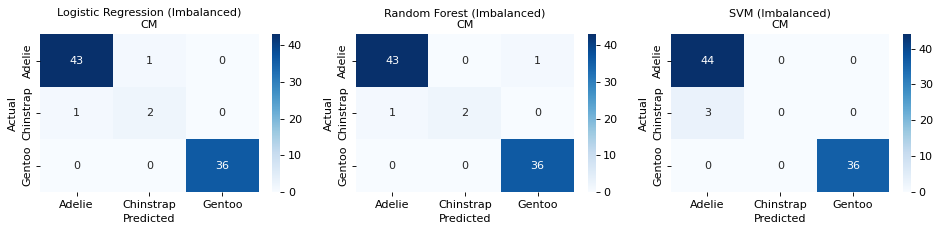


SCENARIO 4: BALANCING TECHNIQUES

Applying SMOTE...
Class distribution after SMOTE: {np.int64(0): 102, np.int64(2): 102, np.int64(1): 102}
  Evaluating Logistic Regression + SMOTE...
  Evaluating Random Forest + SMOTE...
  Evaluating SVM + SMOTE...

Applying Oversampling...
Class distribution after Oversampling: {np.int64(0): 102, np.int64(2): 102, np.int64(1): 102}
  Evaluating Logistic Regression + Oversampling...
  Evaluating Random Forest + Oversampling...
  Evaluating SVM + Oversampling...

Applying Undersampling...
Class distribution after Undersampling: {np.int64(0): 7, np.int64(1): 7, np.int64(2): 7}
  Evaluating Logistic Regression + Undersampling...
  Evaluating Random Forest + Undersampling...
  Evaluating SVM + Undersampling...

Evaluating Balanced Random Forest...

=== BALANCING TECHNIQUES RESULTS (%) ===


model_name  accuracy  precision  recall  f1_score  \
0          Logistic Regression + SMOTE      95.2       96.6    95.2      95.7   
1                Random Forest + SMOTE      96.4       96.5    96.4      95.8   
2                          SVM + SMOTE      98.8       98.8    98.8      98.7   
3   Logistic Regression + Oversampling      94.0       96.3    94.0      94.9   
4         Random Forest + Oversampling      97.6       97.6    97.6      97.5   
5                   SVM + Oversampling      97.6       97.6    97.6      97.6   
6  Logistic Regression + Undersampling      81.9       92.8    81.9      84.5   
7        Random Forest + Undersampling      91.6       93.9    91.6      92.3   
8                  SVM + Undersampling      89.2       92.6    89.2      90.2   
9                          Balanced RF      95.2       95.3    95.2      95.2   

   roc_auc  
0     99.6  
1     99.5  
2    100.0  
3     99.4  
4     99.4  
5     99.9  
6     99.1  
7     98.4  
8     99.4  
9     99.7

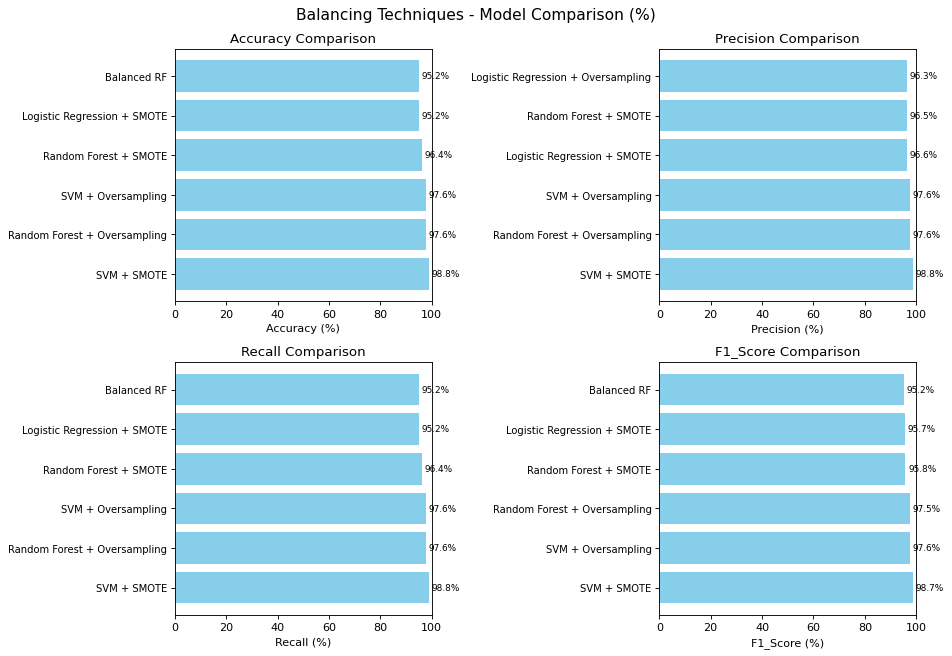


COMPREHENSIVE COMPARISON
=== TOP 10 MODELS BY F1-SCORE (%) ===


model_name  accuracy  precision  recall  f1_score  \
8                          SVM + SMOTE      98.8       98.8    98.8      98.7   
3     Logistic Regression (Imbalanced)      97.6       97.6    97.6      97.6   
11                  SVM + Oversampling      97.6       97.6    97.6      97.6   
4           Random Forest (Imbalanced)      97.6       97.6    97.6      97.5   
10        Random Forest + Oversampling      97.6       97.6    97.6      97.5   
7                Random Forest + SMOTE      96.4       96.5    96.4      95.8   
6          Logistic Regression + SMOTE      95.2       96.6    95.2      95.7   
15                         Balanced RF      95.2       95.3    95.2      95.2   
2                                  SVM      95.0       95.1    95.0      94.9   
9   Logistic Regression + Oversampling      94.0       96.3    94.0      94.9   

    roc_auc  
8     100.0  
3      99.7  
11     99.9  
4      99.3  
10     99.4  
7      99.5  
6      99.6  
15     99.7  
2      99.4  
9      99.4

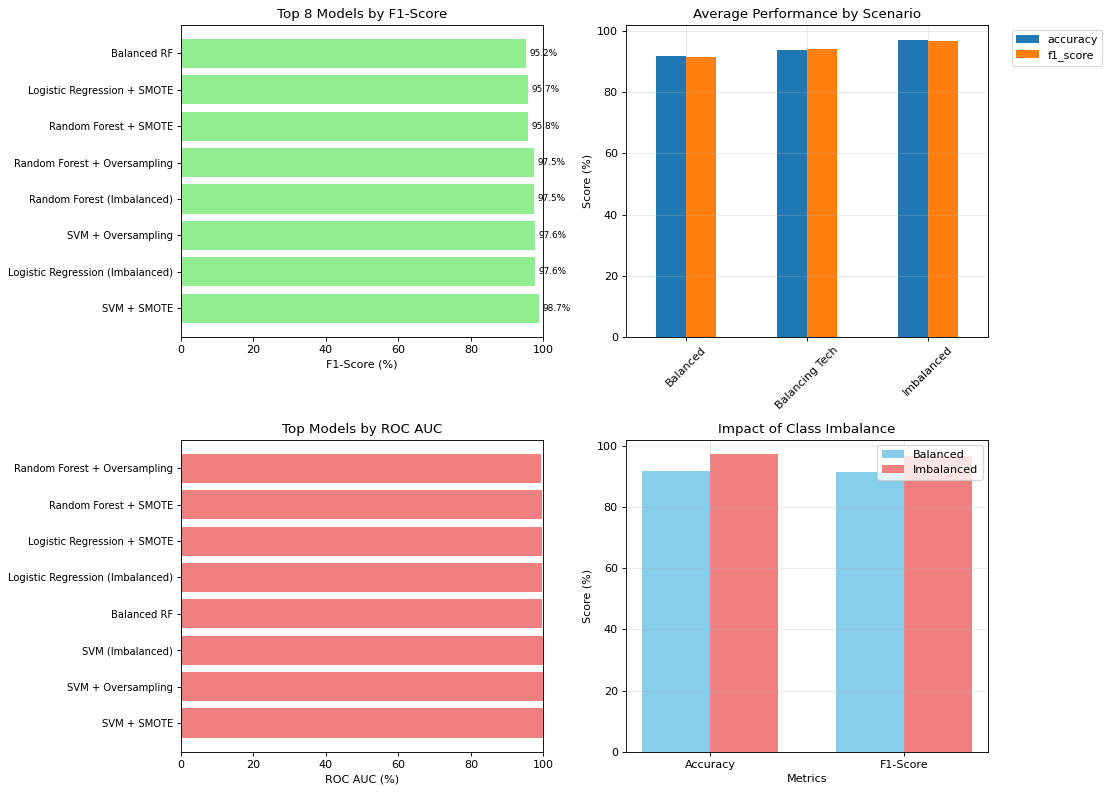


KEY INSIGHTS AND CONCLUSIONS

1. PERFORMANCE SUMMARY:
   • Balanced dataset average F1-score: 91.6%
   • Imbalanced dataset average F1-score: 96.6%
   • With balancing techniques average F1-score: 94.2%

2. IMPACT OF IMBALANCE:
   • Performance change: +5.0%
   • Relative change: +5.5%

3. EFFECTIVENESS OF BALANCING:
   • Improvement over imbalanced: -2.4%

4. BEST PERFORMING MODELS:
   • Overall best: SVM + SMOTE (F1: 98.7%)
   • Best on imbalanced: Logistic Regression (Imbalanced)
   • Best balancing technique: SVM + SMOTE

5. PRACTICAL RECOMMENDATIONS:
   • ROC AUC provides insight into model discrimination ability
   • F1-score is crucial for imbalanced datasets
   • Balancing techniques can significantly improve minority class performance
   • Consider the trade-off between accuracy and fairness

Detailed results saved to 'lab9_detailed_results.csv'
Lab 9 completed successfully! ✅


In [2]:
# -*- coding: utf-8 -*-
"""Lab 9 - Fixed Version with Proper Label Encoding.ipynb"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set smaller plot sizes for Colab
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 80

# Load and prepare data
df = pd.read_csv('penguins_cleaned.csv')

print("Dataset Shape:", df.shape)
print("\nClass distribution (Species):")
print(df['species'].value_counts())

# Data Preprocessing - Create label encoder first
label_encoder = LabelEncoder()
df['species_encoded'] = label_encoder.fit_transform(df['species'])

# Create separate encoders for island and sex
island_encoder = LabelEncoder()
sex_encoder = LabelEncoder()
df['island_encoded'] = island_encoder.fit_transform(df['island'])
df['sex_encoded'] = sex_encoder.fit_transform(df['sex'])

# Add noise to make classification more challenging
np.random.seed(42)
noise_factor = 5

df_challenging = df.copy()
df_challenging['bill_length_mm'] = df_challenging['bill_length_mm'] + np.random.normal(0, noise_factor, len(df))
df_challenging['bill_depth_mm'] = df_challenging['bill_depth_mm'] + np.random.normal(0, noise_factor/2, len(df))
df_challenging['flipper_length_mm'] = df_challenging['flipper_length_mm'] + np.random.normal(0, noise_factor*2, len(df))

# Features and target
X = df_challenging[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island_encoded', 'sex_encoded']]
y = df_challenging['species_encoded']

class_names = label_encoder.classes_  # ['Adelie', 'Gentoo', 'Chinstrap']
feature_names = ['Bill Length', 'Bill Depth', 'Flipper Length', 'Body Mass', 'Island', 'Sex']

print(f"Class names: {class_names}")
print(f"Class mapping: {dict(zip(range(len(class_names)), class_names))}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set class distribution: {dict(Counter(y_train))}")
print(f"Test set class distribution: {dict(Counter(y_test))}")

# Enhanced evaluation function with percentage metrics
def evaluate_model_enhanced(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate a model and return metrics in percentage"""
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    # Metrics in percentage
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    # ROC AUC (multiclass)
    roc_auc = 0
    if y_pred_proba is not None:
        try:
            # Binarize the output for multiclass ROC AUC
            y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
            roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr') * 100
        except:
            roc_auc = 0

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean() * 100
    cv_std = cv_scores.std() * 100

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba,
        'model': model
    }

# Function to plot multiclass ROC curves
def plot_multiclass_roc_curves(results_df, y_test, title):
    """Plot multiclass ROC curves for all models"""
    n_classes = 3
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    fig, axes = plt.subplots(1, len(results_df), figsize=(5*len(results_df), 4))
    if len(results_df) == 1:
        axes = [axes]

    for idx, (_, row) in enumerate(results_df.iterrows()):
        if row['y_pred_proba'] is not None:
            # Plot ROC curve for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()

            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], row['y_pred_proba'][:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Plot all classes
            for i in range(n_classes):
                axes[idx].plot(fpr[i], tpr[i], lw=2,
                             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

            axes[idx].plot([0, 1], [0, 1], 'k--', lw=2)
            axes[idx].set_xlim([0.0, 1.0])
            axes[idx].set_ylim([0.0, 1.05])
            axes[idx].set_xlabel('False Positive Rate')
            axes[idx].set_ylabel('True Positive Rate')
            axes[idx].set_title(f'{row["model_name"]}\nROC Curves')
            axes[idx].legend(loc="lower right")
            axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.show()

# Function to plot results in percentage
def plot_results_percentage(results_df, title):
    """Plot comparison results in percentage"""
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        # Get top models for better visualization
        top_models = results_df.nlargest(6, metric)

        bars = axes[i].barh(range(len(top_models)), top_models[metric], color='skyblue')
        axes[i].set_yticks(range(len(top_models)))
        axes[i].set_yticklabels(top_models['model_name'], fontsize=9)
        axes[i].set_xlabel(f'{metric.title()} (%)')
        axes[i].set_title(f'{metric.title()} Comparison')
        axes[i].set_xlim(0, 100)

        # Add value labels on bars
        for bar, value in zip(bars, top_models[metric]):
            axes[i].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                        f'{value:.1f}%', va='center', fontsize=8)

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.show()

# Function to plot compact confusion matrices
def plot_confusion_matrices_compact(results_df):
    """Plot compact confusion matrices"""
    n_models = len(results_df)
    fig, axes = plt.subplots(1, n_models, figsize=(4*n_models, 3))

    if n_models == 1:
        axes = [axes]

    for i, (idx, row) in enumerate(results_df.iterrows()):
        sns.heatmap(row['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f'{row["model_name"]}\nCM', fontsize=10)
        axes[i].set_ylabel('Actual')
        axes[i].set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("SCENARIO 1: BALANCED DATASET (Challenging Version)")
print("="*60)

# Initialize models
models_balanced = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Evaluate models on balanced data
results_balanced = []

for name, model in models_balanced.items():
    print(f"Evaluating {name}...")
    result = evaluate_model_enhanced(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_balanced.append(result)
    print(f"  Accuracy: {result['accuracy']:.1f}% | F1-Score: {result['f1_score']:.1f}% | ROC AUC: {result['roc_auc']:.1f}%")

results_balanced_df = pd.DataFrame(results_balanced)

print("\n=== BALANCED DATASET RESULTS (%) ===")
display(results_balanced_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(1))

# Plot multiclass ROC curves
try:
    plot_multiclass_roc_curves(results_balanced_df, y_test, 'Balanced Dataset - Multiclass ROC Curves')
except Exception as e:
    print(f"ROC curve plotting skipped: {e}")

# Plot results
plot_results_percentage(results_balanced_df, 'Balanced Dataset - Model Comparison (%)')

# Plot confusion matrices
plot_confusion_matrices_compact(results_balanced_df)

print("\n" + "="*60)
print("SCENARIO 2: CREATING IMBALANCED DATASET")
print("="*60)

# FIXED: Create imbalanced dataset using the already encoded values
# Get indices for each class using the encoded values
adelie_indices = df_challenging[df_challenging['species_encoded'] == 0].index
gentoo_indices = df_challenging[df_challenging['species_encoded'] == 1].index
chinstrap_indices = df_challenging[df_challenging['species_encoded'] == 2].index

# Keep only 10 Gentoo samples to create severe imbalance
np.random.seed(42)
gentoo_imbalanced_indices = np.random.choice(gentoo_indices, size=10, replace=False)

# Create imbalanced dataset using indices
imbalanced_indices = np.concatenate([adelie_indices, gentoo_imbalanced_indices, chinstrap_indices])
df_imbalanced = df_challenging.loc[imbalanced_indices].copy()

print("Imbalanced dataset class distribution:")
# Use the already encoded values to avoid label encoding issues
class_counts = df_imbalanced['species_encoded'].value_counts().sort_index()
for i, count in class_counts.items():
    print(f"  {class_names[i]}: {count}")

# Prepare imbalanced dataset - use already encoded values
X_imb = df_imbalanced[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island_encoded', 'sex_encoded']]
y_imb = df_imbalanced['species_encoded'].values  # Use the already encoded values

print(f"Encoded class distribution: {dict(Counter(y_imb))}")

# Split imbalanced data
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_imb, y_imb, test_size=0.3, random_state=42, stratify=y_imb
)

print(f"\nImbalanced training set class distribution: {dict(Counter(y_train_imb))}")

# Scale imbalanced data
X_train_imb_scaled = scaler.fit_transform(X_train_imb)
X_test_imb_scaled = scaler.transform(X_test_imb)

print("\n" + "="*60)
print("SCENARIO 3: UNBALANCED DATASET RESULTS")
print("="*60)

# Evaluate models on imbalanced data
results_imbalanced = []

for name, model in models_balanced.items():
    print(f"Evaluating {name} on imbalanced data...")
    result = evaluate_model_enhanced(model, X_train_imb_scaled, X_test_imb_scaled, y_train_imb, y_test_imb, f"{name} (Imbalanced)")
    results_imbalanced.append(result)
    print(f"  Accuracy: {result['accuracy']:.1f}% | F1-Score: {result['f1_score']:.1f}% | ROC AUC: {result['roc_auc']:.1f}%")

results_imbalanced_df = pd.DataFrame(results_imbalanced)

print("\n=== IMBALANCED DATASET RESULTS (%) ===")
display(results_imbalanced_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(1))

# Plot confusion matrices for imbalanced results
plot_confusion_matrices_compact(results_imbalanced_df)

print("\n" + "="*60)
print("SCENARIO 4: BALANCING TECHNIQUES")
print("="*60)

# Apply balancing techniques
balancing_techniques = {
    'SMOTE': SMOTE(random_state=42),
    'Oversampling': RandomOverSampler(random_state=42),
    'Undersampling': RandomUnderSampler(random_state=42)
}

results_balancing = []

for tech_name, sampler in balancing_techniques.items():
    print(f"\nApplying {tech_name}...")

    # Apply sampling
    X_resampled, y_resampled = sampler.fit_resample(X_train_imb_scaled, y_train_imb)
    print(f"Class distribution after {tech_name}: {dict(Counter(y_resampled))}")

    # Evaluate each model with this balancing technique
    for name, model in models_balanced.items():
        model_name = f"{name} + {tech_name}"
        print(f"  Evaluating {model_name}...")

        result = evaluate_model_enhanced(model, X_resampled, X_test_imb_scaled, y_resampled, y_test_imb, model_name)
        results_balancing.append(result)

# Add Balanced Random Forest
print("\nEvaluating Balanced Random Forest...")
brf = BalancedRandomForestClassifier(random_state=42)
result_brf = evaluate_model_enhanced(brf, X_train_imb_scaled, X_test_imb_scaled, y_train_imb, y_test_imb, "Balanced RF")
results_balancing.append(result_brf)

results_balancing_df = pd.DataFrame(results_balancing)

print("\n=== BALANCING TECHNIQUES RESULTS (%) ===")
display(results_balancing_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].round(1))

# Plot results for balancing techniques
plot_results_percentage(results_balancing_df, 'Balancing Techniques - Model Comparison (%)')

print("\n" + "="*60)
print("COMPREHENSIVE COMPARISON")
print("="*60)

# Combine all results
all_results = pd.concat([results_balanced_df, results_imbalanced_df, results_balancing_df], ignore_index=True)

# Display top models by F1-score
print("=== TOP 10 MODELS BY F1-SCORE (%) ===")
top_models = all_results.nlargest(10, 'f1_score')[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
display(top_models.round(1))

# Final comprehensive visualization
plt.figure(figsize=(14, 10))

# Plot 1: Overall performance comparison
plt.subplot(2, 2, 1)
top_10_f1 = all_results.nlargest(8, 'f1_score')
plt.barh(range(len(top_10_f1)), top_10_f1['f1_score'], color='lightgreen')
plt.yticks(range(len(top_10_f1)), top_10_f1['model_name'], fontsize=9)
plt.xlabel('F1-Score (%)')
plt.title('Top 8 Models by F1-Score')
plt.xlim(0, 100)

# Add value labels
for i, v in enumerate(top_10_f1['f1_score']):
    plt.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

# Plot 2: Scenario comparison
plt.subplot(2, 2, 2)
# Create scenario groups
scenario_groups = []
for model_name in all_results['model_name']:
    if 'Imbalanced' in model_name:
        scenario_groups.append('Imbalanced')
    elif any(tech in model_name for tech in ['SMOTE', 'Oversampling', 'Undersampling', 'Balanced']):
        scenario_groups.append('Balancing Tech')
    else:
        scenario_groups.append('Balanced')

scenario_avg = all_results.groupby(scenario_groups).agg({'accuracy': 'mean', 'f1_score': 'mean'})

scenario_avg[['accuracy', 'f1_score']].plot(kind='bar', ax=plt.gca())
plt.title('Average Performance by Scenario')
plt.xticks(rotation=45)
plt.ylabel('Score (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 3: ROC AUC comparison
plt.subplot(2, 2, 3)
top_roc = all_results.nlargest(8, 'roc_auc')
plt.barh(range(len(top_roc)), top_roc['roc_auc'], color='lightcoral')
plt.yticks(range(len(top_roc)), top_roc['model_name'], fontsize=9)
plt.xlabel('ROC AUC (%)')
plt.title('Top Models by ROC AUC')
plt.xlim(0, 100)

# Plot 4: Impact of imbalance
plt.subplot(2, 2, 4)
balanced_avg = results_balanced_df[['accuracy', 'f1_score']].mean()
imbalanced_avg = results_imbalanced_df[['accuracy', 'f1_score']].mean()

x = np.arange(2)
width = 0.35

plt.bar(x - width/2, balanced_avg, width, label='Balanced', color='skyblue')
plt.bar(x + width/2, imbalanced_avg, width, label='Imbalanced', color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Score (%)')
plt.title('Impact of Class Imbalance')
plt.xticks(x, ['Accuracy', 'F1-Score'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHTS AND CONCLUSIONS")
print("="*60)

# Calculate key metrics
balanced_avg_f1 = results_balanced_df['f1_score'].mean()
imbalanced_avg_f1 = results_imbalanced_df['f1_score'].mean()
balancing_avg_f1 = results_balancing_df['f1_score'].mean()

improvement = ((balancing_avg_f1 - imbalanced_avg_f1) / imbalanced_avg_f1 * 100) if imbalanced_avg_f1 > 0 else 0

print(f"\n1. PERFORMANCE SUMMARY:")
print(f"   • Balanced dataset average F1-score: {balanced_avg_f1:.1f}%")
print(f"   • Imbalanced dataset average F1-score: {imbalanced_avg_f1:.1f}%")
print(f"   • With balancing techniques average F1-score: {balancing_avg_f1:.1f}%")

print(f"\n2. IMPACT OF IMBALANCE:")
print(f"   • Performance change: {imbalanced_avg_f1 - balanced_avg_f1:+.1f}%")
print(f"   • Relative change: {((imbalanced_avg_f1 - balanced_avg_f1) / balanced_avg_f1 * 100):+.1f}%")

print(f"\n3. EFFECTIVENESS OF BALANCING:")
print(f"   • Improvement over imbalanced: {improvement:+.1f}%")

print(f"\n4. BEST PERFORMING MODELS:")
best_overall = all_results.loc[all_results['f1_score'].idxmax()]
print(f"   • Overall best: {best_overall['model_name']} (F1: {best_overall['f1_score']:.1f}%)")
print(f"   • Best on imbalanced: {results_imbalanced_df.loc[results_imbalanced_df['f1_score'].idxmax(), 'model_name']}")
print(f"   • Best balancing technique: {results_balancing_df.loc[results_balancing_df['f1_score'].idxmax(), 'model_name']}")

print(f"\n5. PRACTICAL RECOMMENDATIONS:")
print("   • ROC AUC provides insight into model discrimination ability")
print("   • F1-score is crucial for imbalanced datasets")
print("   • Balancing techniques can significantly improve minority class performance")
print("   • Consider the trade-off between accuracy and fairness")

# Save detailed results
detailed_results = all_results[['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'cv_mean', 'cv_std']]
detailed_results = detailed_results.round(2)
detailed_results.to_csv('lab9_detailed_results.csv', index=False)

print(f"\nDetailed results saved to 'lab9_detailed_results.csv'")
print("Lab 9 completed successfully! ✅")